# Exercises


## Image Processing

1. Apply AWGN to an image and then evaluate what filter between: Gaussian, Median, Sharpening and Resizing better attenuate the noise induced by the AWGN
2. Convert a RGB image into YCbCr, apply compressions and other processing and evaluate which components deteriorate the most the resulting RGB image.
3. Extract edges from an image and localize in these regions an attack.

(512, 512)


C:\Users\andre\AppData\Local\Temp\ipykernel_16900\3547056826.py:16: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


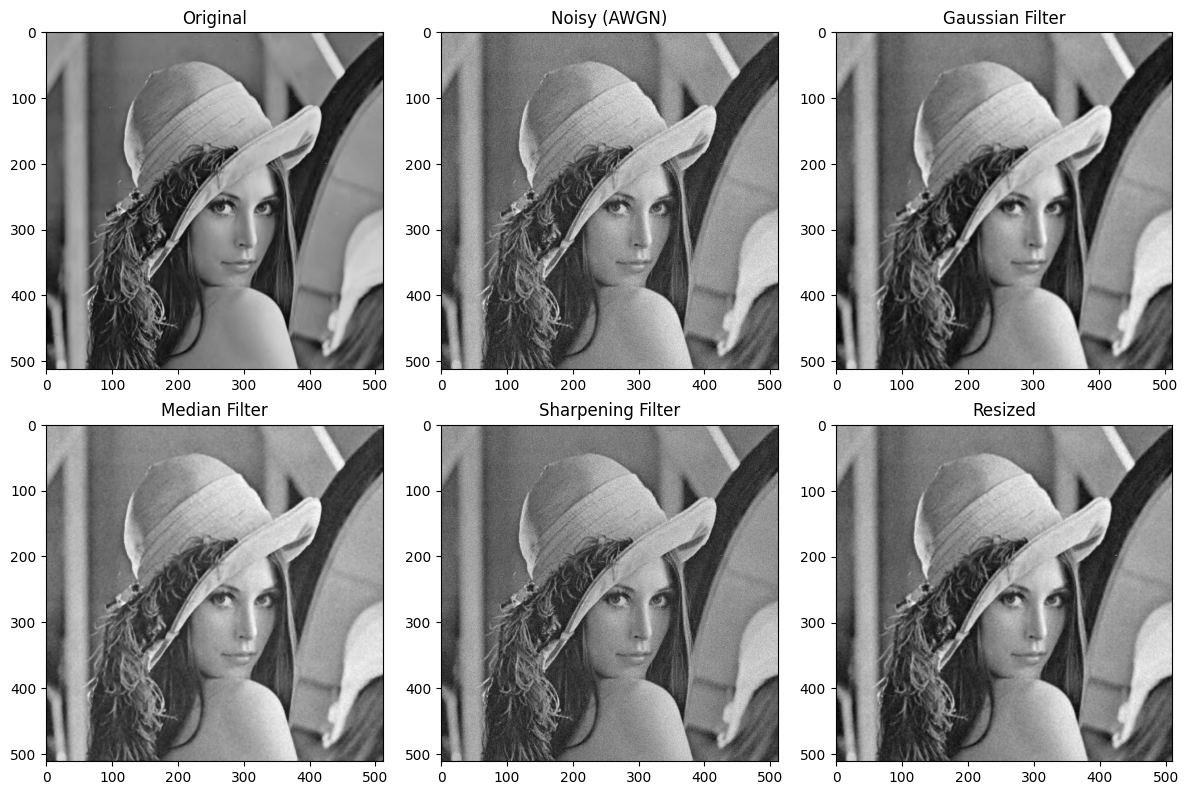

You should play with different values of the parameters used to apply AWGN and the other filters. 
However, for these combination the filter choice is between the Median and the Gaussian filter. 
Specifically, the Median filter preserve textures much better than the Gaussian one.


In [36]:
#1. Apply awgn to an image...

import cv2
import numpy as np
from matplotlib import pyplot as plt

# Function to add AWGN to an image
def awgn(img, std, seed):
  mean = 0.0   # some constant
  np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return attacked

def blur(img, sigma):
  from scipy.ndimage.filters import gaussian_filter
  attacked = gaussian_filter(img, sigma)
  return attacked

def sharpening(img, sigma, alpha):
  import scipy
  from scipy.ndimage import gaussian_filter
  import matplotlib.pyplot as plt

  #print(img/255)
  filter_blurred_f = gaussian_filter(img, sigma)

  attacked = img + alpha * (img - filter_blurred_f)
  return attacked

def median(img, kernel_size):
  from scipy.signal import medfilt
  attacked = medfilt(img, kernel_size)
  return attacked

def resizing(img, scale):
  from skimage.transform import rescale
  x, y = img.shape
  attacked = rescale(img, scale)
  attacked = rescale(attacked, 1/scale)
  attacked = attacked[:x, :y]
  return attacked



# Load the image
image = cv2.imread('lena_grey.bmp', cv2.IMREAD_GRAYSCALE)
# Apply AWGN to the image
noisy_image = awgn(image, 10, 123)
print(np.shape(noisy_image))

# Apply different filters
#play with sigma
gaussian_filtered = blur(noisy_image, 1)
median_filtered = median(noisy_image, 3)
sharpened_image = sharpening(noisy_image, 1, 0.1)
resized_image = resizing(noisy_image, 0.7)

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(image,cmap='gray')
plt.title("Original")

plt.subplot(2, 3, 2)
plt.imshow(noisy_image,cmap='gray')
plt.title("Noisy (AWGN)")

plt.subplot(2, 3, 3)
plt.imshow(gaussian_filtered,cmap='gray')
plt.title("Gaussian Filter")

plt.subplot(2, 3, 4)
plt.imshow(median_filtered,cmap='gray')
plt.title("Median Filter")

plt.subplot(2, 3, 5)
plt.imshow(sharpened_image,cmap='gray')
plt.title("Sharpening Filter")

plt.subplot(2, 3, 6)
plt.imshow(resized_image,cmap='gray')
plt.title("Resized")

plt.tight_layout()
plt.show()

print('You should play with different values of the parameters used to apply AWGN and the other filters. \nHowever, for these combination the filter choice is between the Median and the Gaussian filter. \nSpecifically, the Median filter preserve textures much better than the Gaussian one.')


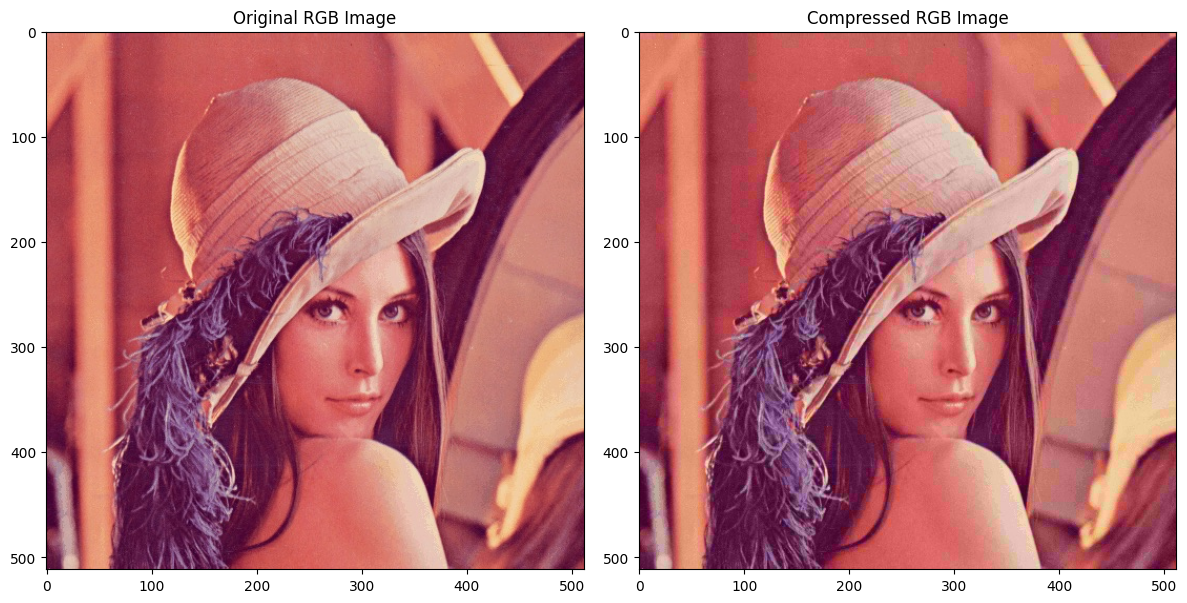

Compressing the Y channel, visually degrade the compressed image more 
than compressing with the same QF both the Cb and Cr channel.


In [37]:
#2. Convert a RGB image to YCbCr...
import os

def jpeg_compression(img, QF):
  from PIL import Image
  img = Image.fromarray(img)
  img.save('tmp.jpg',"JPEG", quality=QF)
  attacked = Image.open('tmp.jpg')
  attacked = np.asarray(attacked,dtype=np.uint8)
  os.remove('tmp.jpg')

  return attacked


# Convert RGB to YCbCr
# Load the image
image = cv2.imread('lena_color.jpg')
ycbcr_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

# Compress YCbCr channels
#PLAY WITH THE QF param. try to set Cb, Cr to 100 and Y to 10.
y_compressed = jpeg_compression(ycbcr_image[:,:,0], 100)
cb_compressed = jpeg_compression(ycbcr_image[:,:,1], 10)
cr_compressed = jpeg_compression(ycbcr_image[:,:,2], 10)

# Merge compressed channels back
ycbcr_compressed = cv2.merge([y_compressed, cb_compressed, cr_compressed])

# Convert back to RGB for comparison
rgb_compressed = cv2.cvtColor(ycbcr_compressed, cv2.COLOR_YCrCb2RGB)

# Plot the original and compressed image
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image,  cv2.COLOR_BGR2RGB))
plt.title("Original RGB Image")

plt.subplot(1, 2, 2)
plt.imshow(rgb_compressed)
plt.title("Compressed RGB Image")

plt.tight_layout()
plt.show()

print('Compressing the Y channel, visually degrade the compressed image more \nthan compressing with the same QF both the Cb and Cr channel.')

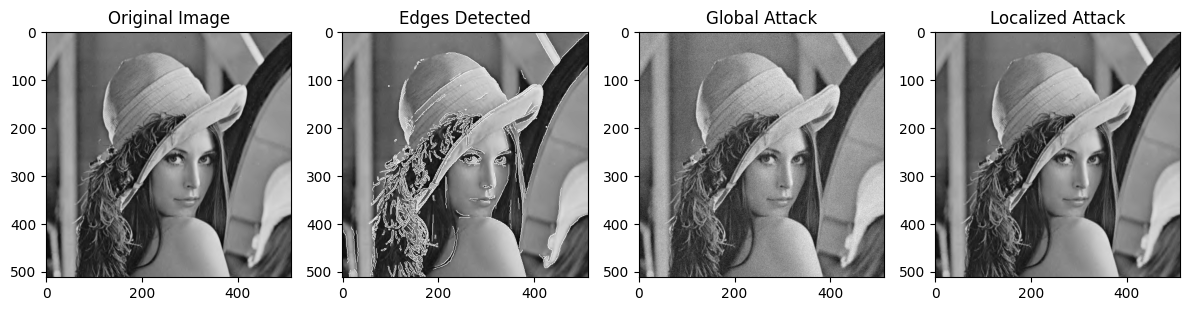

Final check to know we localized the attacks
Values of the pixels before applying AWGN locally to the image:  [174 150 157 ...  92  95 147]
Values of the attacked pixels after applying AWGN globally to the entire image:  [160.90834686 143.11451468 161.16123814 ...  93.42399244  84.04546013
 127.4688196 ]
Values of the attacked pixels after applying AWGN locally to the image:  [160 143 161 ...  93  84 127]
As you can see, localize the attack to textured regions improve its quality in terms of invisibility!!!


In [38]:
#3. Extract Edges...

def awgn(img, std, seed):
  mean = 0.0   # some constant
  np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return attacked

# Convert the image to grayscale for edge detection
gray_image = cv2.imread('lena_grey.bmp', cv2.IMREAD_GRAYSCALE)
#create a copy of this image where we will localize the attack
localized_Attack = gray_image.copy()
#create a copy of this image where we will localize the edges
edges_results = gray_image.copy()
# attack the entire image
attacked = awgn(gray_image, 10, 123)

# Apply Canny edge detection
edges = cv2.Canny(gray_image, 100, 200)

#localize edges 
edges_results[edges > 0] = [255]

#localize the AWGN attack on edges
localized_Attack[edges > 0] = attacked[edges > 0] 


# Plot original image and edges
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.imshow(gray_image, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 4, 2)
plt.imshow(edges_results, cmap='gray')
plt.title("Edges Detected")

plt.subplot(1, 4, 3)
plt.imshow(attacked, cmap='gray')
plt.title("Global Attack")

plt.subplot(1, 4, 4)
plt.imshow(localized_Attack, cmap='gray')
plt.title("Localized Attack")

plt.tight_layout()
plt.show()


print('Final check to know we localized the attacks')
print('Values of the pixels before applying AWGN locally to the image: ', gray_image[edges > 0])
print('Values of the attacked pixels after applying AWGN globally to the entire image: ', attacked[edges > 0])
print('Values of the attacked pixels after applying AWGN locally to the image: ',localized_Attack[edges > 0])

print('As you can see, localize the attack to textured regions improve its quality in terms of invisibility!!!')


## DCT Exercise

What frequencies are THE MOST important for DCT? 

* remove the DC component
* remove low and high frequencies

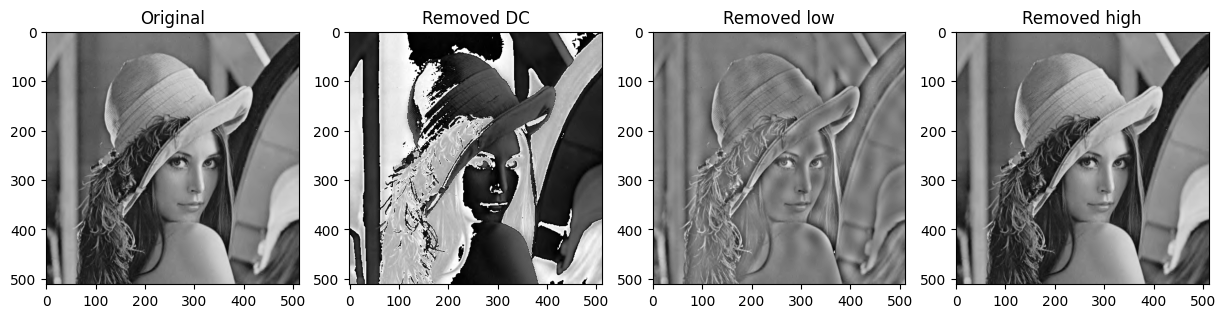

In [39]:
from scipy.fft import dct, idct
gray_image = cv2.imread('lena_grey.bmp', cv2.IMREAD_GRAYSCALE)

transform =  dct(dct(gray_image,axis=0, norm='ortho'),axis=1, norm='ortho')

# remove DC frequencies
edited1 = transform.copy()
edited1[0, 0] = 0
edited1 = np.uint8(idct(idct(edited1,axis=1, norm='ortho'),axis=0, norm='ortho'))


# remove low freqs
edited2 = transform.copy()
edited2[:20, :20] = 0
edited2[0, 0] = transform[0, 0]
edited2 = np.uint8(idct(idct(edited2,axis=1, norm='ortho'),axis=0, norm='ortho'))

# remove high freqs
edited3 = transform.copy()
edited3[512-20:, 512-20:] = 0
edited3 = np.uint8(idct(idct(edited3,axis=1, norm='ortho'),axis=0, norm='ortho'))

plt.figure(figsize=(15, 9))
plt.subplot(141)
plt.title('Original')
plt.imshow(gray_image, cmap='gray')
plt.subplot(142)
plt.title('Removed DC')
plt.imshow(edited1, cmap='gray')
plt.subplot(143)
plt.title('Removed low')
plt.imshow(edited2, cmap='gray')
plt.subplot(144)
plt.title('Removed high')
plt.imshow(edited3, cmap='gray')
plt.show()

## Wavelet (DWT):
* remove each subband and see what happens
* visualize the second level decomposition

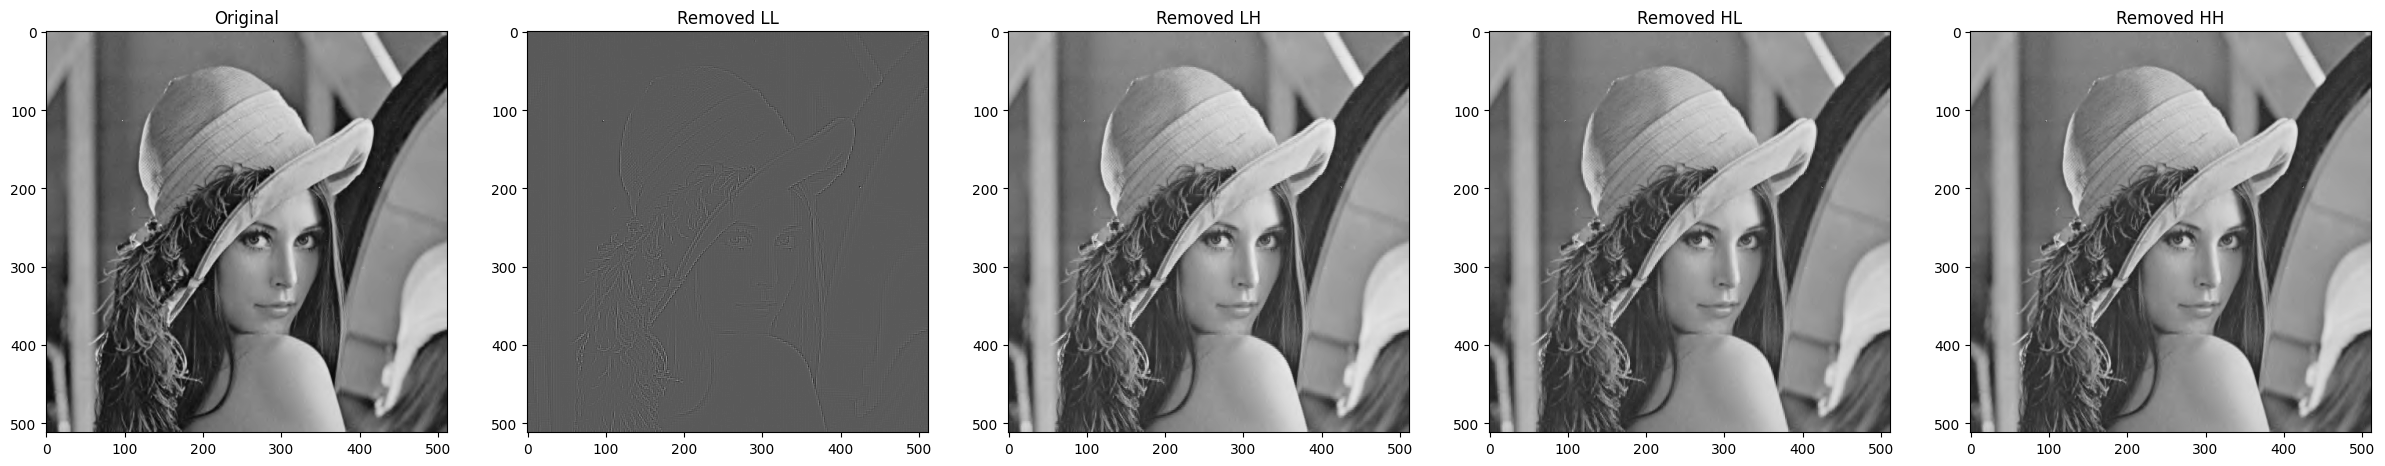

In [40]:
import pywt
gray_image = cv2.imread('lena_grey.bmp', cv2.IMREAD_GRAYSCALE)

coeffs2 = pywt.dwt2(gray_image, 'haar')

LL, (LH, HL, HH) = coeffs2

LL_edited = LL.copy()
LL_edited[:, :] = 0
LL_res = pywt.idwt2((LL_edited, (LH, HL, HH)), 'haar')

LH_edited = LH.copy()
LH_edited[:, :] = 0
LH_res = pywt.idwt2((LL, (LH_edited, HL, HH)), 'haar')

HL_edited = HL.copy()
HL_edited[:, :] = 0
HL_res = pywt.idwt2((LL, (LH, HL_edited, HH)), 'haar')

HH_edited = HH.copy()
HH_edited[:, :] = 0
HH_res = pywt.idwt2((LL, (LH, HL, HH_edited)), 'haar')


# Show components
plt.figure(figsize=(30, 15))
plt.subplot(151)
plt.title('Original')
plt.imshow(gray_image, cmap='gray')
plt.subplot(152)
plt.title('Removed LL')
plt.imshow(LL_res, cmap='gray')
plt.subplot(153)
plt.title('Removed LH')
plt.imshow(LH_res, cmap='gray')
plt.subplot(154)
plt.title('Removed HL')
plt.imshow(HL_res, cmap='gray')
plt.subplot(155)
plt.title('Removed HH')
plt.imshow(HH_res, cmap='gray')
plt.show()


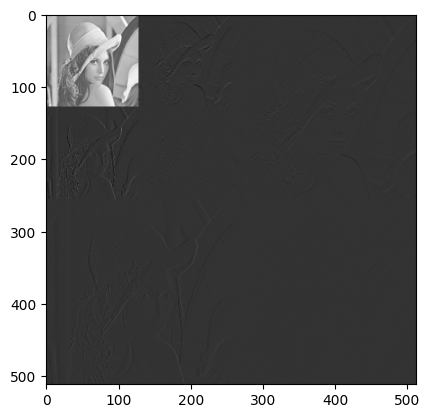

In [41]:
import pywt
coeffs2_2 = pywt.dwt2(LL, 'haar')
LL2, (LH2, HL2, HH2) = coeffs2_2

blank_image = np.zeros((512,512), np.float32)
blank_image[:128, :128] = LL2
blank_image[:128, 128:256] = LH2
blank_image[128:256, :128] = HL2
blank_image[128:256, 128:256] = HH2
blank_image[:256, 256:] = LH
blank_image[256:, :256] = HL
blank_image[256:, 256:] = HH

# Show components
plt.imshow(blank_image, cmap='gray')

## Final Challenge

Do this exercise and then come to me so I can review it. It is not sure I will publish the solutions ;-)

Using the Fourier Transform, DCT or DWT, localize a specific kind of frequencies (you choose), and apply a localized attack. Which attack visually deteriorate the most the results image? Which frequencies, once attacked contribute the less to the image deterioration?